![Winsconsin](img/winsconsin.jpeg)

🩻 **Classification de tumeurs à partir de données médicales**

**Contexte** :
Vous intégrez une équipe de développement en intelligence artificielle dans le cadre d’un projet pilote mené par un consortium de recherche médicale basé dans l’État du Wisconsin, aux États-Unis. Ce projet vise à concevoir des outils numériques d’aide au diagnostic précoce du cancer du sein, en collaboration avec des centres hospitaliers universitaires et des laboratoires d’analyses.

Dans ce cadre, un jeu de données clinique réel — le **Breast Cancer Wisconsin Diagnostic Dataset**, collecté par le Dr. William H. Wolberg au sein de l’université du Wisconsin — a été mis à disposition. Ce dataset contient les caractéristiques de cellules prélevées lors de biopsies mammaires, classées manuellement comme tumeurs bénignes ou malignes.

⸻

🎯 **Objectif** :

Votre mission consiste à concevoir un prototype fonctionnel permettant de prédire la nature de la tumeur à partir de ces données, via un modèle de classification en apprentissage supervisé ([**régression logistique**](https://www.w3schools.com/python/python_ml_logistic_regression.asp)). L’objectif est de démontrer la faisabilité d’un outil automatisé pouvant compléter l’expertise des médecins dans l’analyse de résultats de biopsies.

Construire un modèle de régression logistique capable de prédire la variable `diagnosis` à partir des caractéristiques disponibles dans le fichier ([`data/breast_cancer_wisconsin.csv`](data/breast_cancer_wisconsin.csv)).  

Pour comprendre le dataset, vous pouvez consulter cette page kaggle : https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

- Exploration des données (EDA) :
    - Comprendre les variables (qualitatives/quantitatives)
	- Statistiques descriptives
	- Visualisations (histogrammes, heatmap de corrélation, etc.)
- Préparation des données :
    - Traitement des valeurs manquantes sinécessaire
	- **Transformation des variables catégorielles** (`diagnosis`)
	- **Création éventuelle de nouvelles features**
	- Standardisation si nécessaire
    - Séparation train/test
- Modélisation :
    - Implémentation d’un modèle de régression logistique
- Évaluation du modèle :
    - Calcul des métriques : accuracy, precision, recall, f1-score
    - Matrice de confusion 
    - Bonus : [Étudier AUC - ROC curve](https://www.w3schools.com/python/python_ml_auc_roc.asp)
- Intégration simple du modèle dans un script interactif
    - Intégrer votre modèle dans un script Python simple qui permet à un utilisateur de faire une prédiction à partir de nouvelles données.

⚠️ Attention aux variables fortement corrélées

Le jeu de données Breast Cancer Wisconsin contient plusieurs variables fortement corrélées entre elles, notamment :
- `radius_mean`, `perimeter_mean`, `area_mean`
- ainsi que leurs déclinaisons en `_se` et `_worst`

Cela peut poser des problèmes de multicolinéarité, particulièrement si vous utilisez des modèles linéaires (régression logistique, SVM linéaire, etc.). Ces redondances peuvent fausser les résultats ou générer un sur-apprentissage.

➤ Recommandations :
- Identifiez les corrélations fortes à l’aide d’une matrice de corrélation ou d’une heatmap
- En cas de corrélation > 0.9 entre deux variables, conservez une seule variable du groupe
- Bonus (niveau légende 😈) : vous pouvez également étudier et appliquer une [réduction de dimension type PCA (Pricipal Component Analysis)](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-de-donnees-exploratoire/5280368-comprenez-lenjeu-de-lanalyse-en-composantes-principales) si vous souhaitez automatiser le traitement de la redondance

# Import des bibliothèques
___

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Data loading
___

In [531]:
df = pd.read_csv("data/breast_cancer_wisconsin.csv")

# 2. Exploration
___

### 2.1 Analyses statistiques basiques

Chaque observation représente une tumeur, décrite par 30 variables numériques.

Ces 30 features sont dérivées de 10 propriétés de base, mesurées de trois façons :
- mean
- se (standard error)
- worst

Les 10 propriétés de base :
- radius — rayon moyen
- texture — texture
- perimeter — périmètre
- area — aire
- smoothness — régularité des contours
- compactness — compacité
- concavity — gravité des creux dans les contours
- concave points — nombre de points concaves
- symmetry — symétrie
- fractal dimension — complexité du contour

In [532]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Le dataset contient 569 individus, pour lesquels il n'y a aucune valeur manquante. Toutes les colonnes sont numériques, à l’exception de la colonne `diagnosis` qu’il faudra encoder et qui est d'ailleurs notre **target**. 

Concernant la colonne id, elle ne sera d’aucune utilité pour notre travail.

In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [534]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### 2.2 Analyses de la distribution des features

> Présence de nombreuses valeurs extrêmes
- Presque toutes les variables montrent des points isolés, surtout du côté droit (valeurs élevées).
- Cela indique que beaucoup de caractéristiques présentent une distribution asymétrique avec des valeurs extrêmes.
- Exemples frappants : area_worst, area_mean, concavity_worst, concave points_worst, radius_worst.

> Échelle très variable selon les variables
- Certaines variables vont de 0 à 0.1 (ex : fractal_dimension_se), d’autres vont jusqu’à 4000 (ex : area_worst).
- Cela signifie que la normalisation ou la standardisation sera essentielle avant d’entraîner un modèle.

> Importance des variables *_worst
- Les variables avec le suffixe _worst semblent avoir une variabilité plus grande et des distributions parfois mieux séparées.
- Cela suggère qu’elles peuvent avoir un impact significatif dans un modèle prédictif.

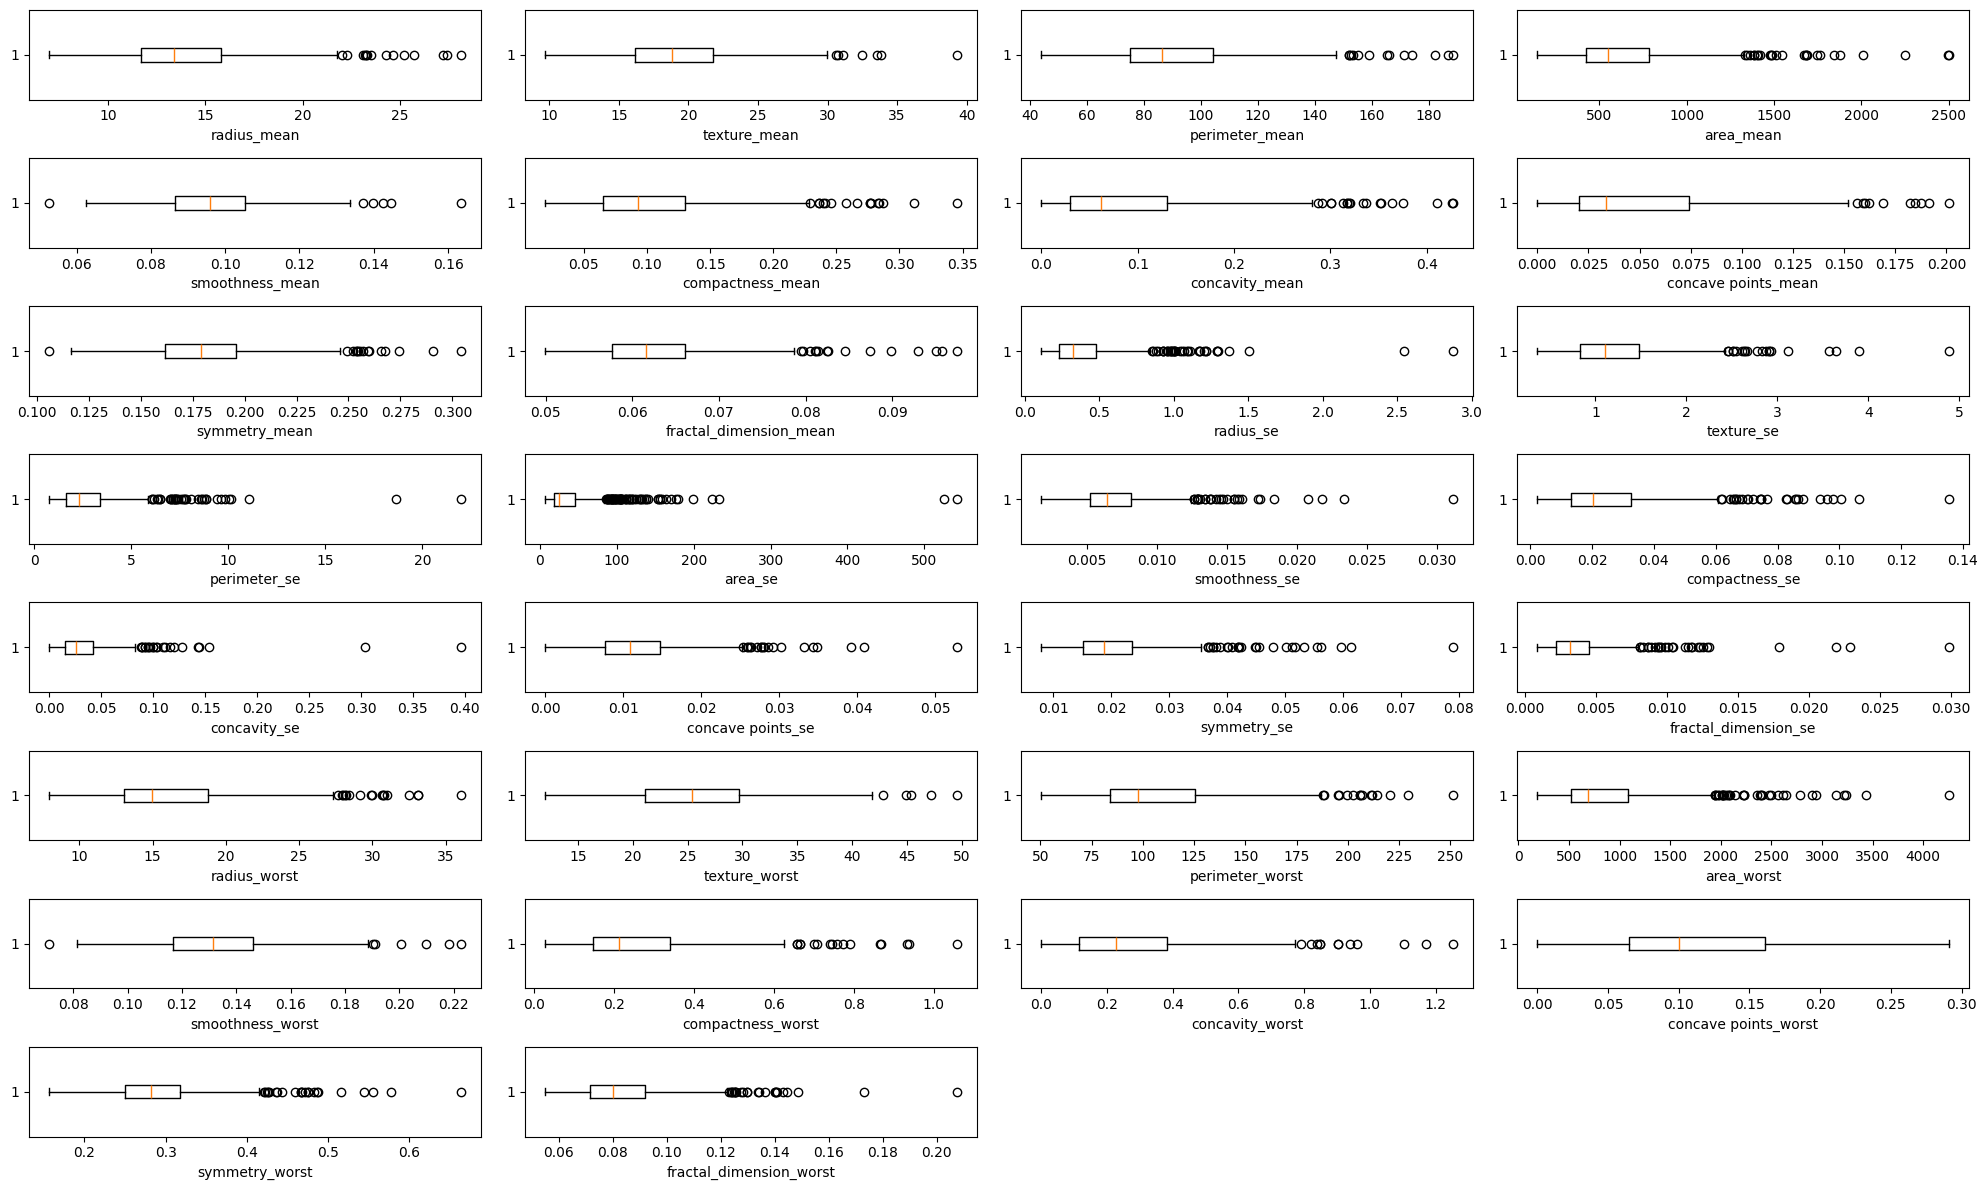

In [535]:
NB_COLS = 4
plt.figure(figsize=(20, 12))

selected_cols = df.drop(["id", "diagnosis"], axis=1).columns
cols = enumerate(selected_cols, 1)
for i, col in cols:
    plt.subplot(round(len(selected_cols)/NB_COLS), NB_COLS, i)
    plt.boxplot(df[col], vert=False)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### 2.2 Analyses des distribution en fonction des classes à prédire

Des variables comme radius_mean, perimeter_mean, area_mean, concavity_mean ou encore concave points_worst présentent une séparation nette entre les deux types de diagnostic (M pour malin et B pour bénin).
Les deux groupes montrent des distributions clairement décalées, ce qui renforce leur intérêt prédictif.

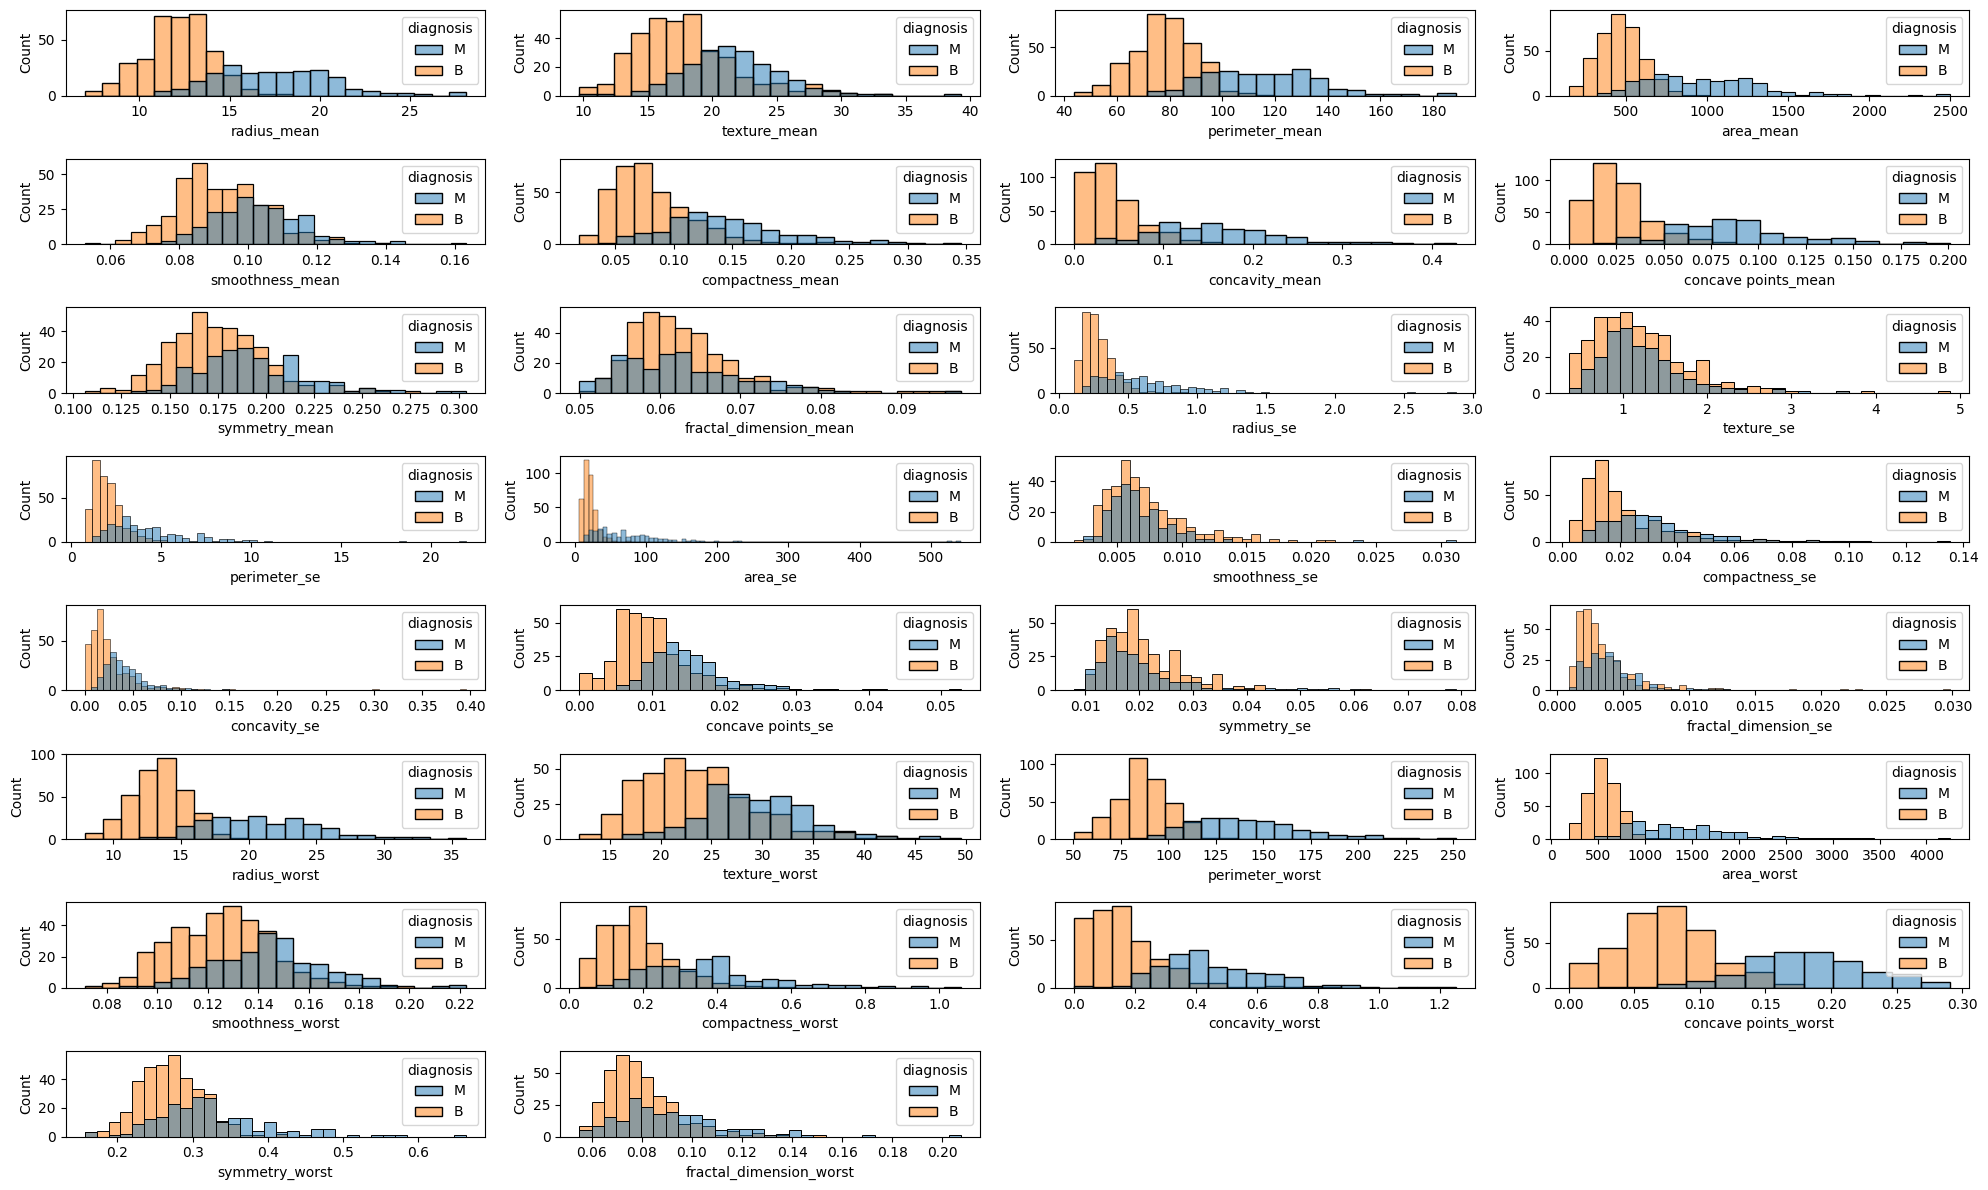

In [536]:
NB_COLS = 4
plt.figure(figsize=(20, 12))

selected_cols = df.drop(["id", "diagnosis"], axis=1).columns
cols = enumerate(selected_cols, 1)
for i, col in cols:
    plt.subplot(round(len(selected_cols)/NB_COLS), NB_COLS, i)
    sns.histplot(data=df, x=df[col], hue="diagnosis")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### 2.3 Visualisation des corrélations

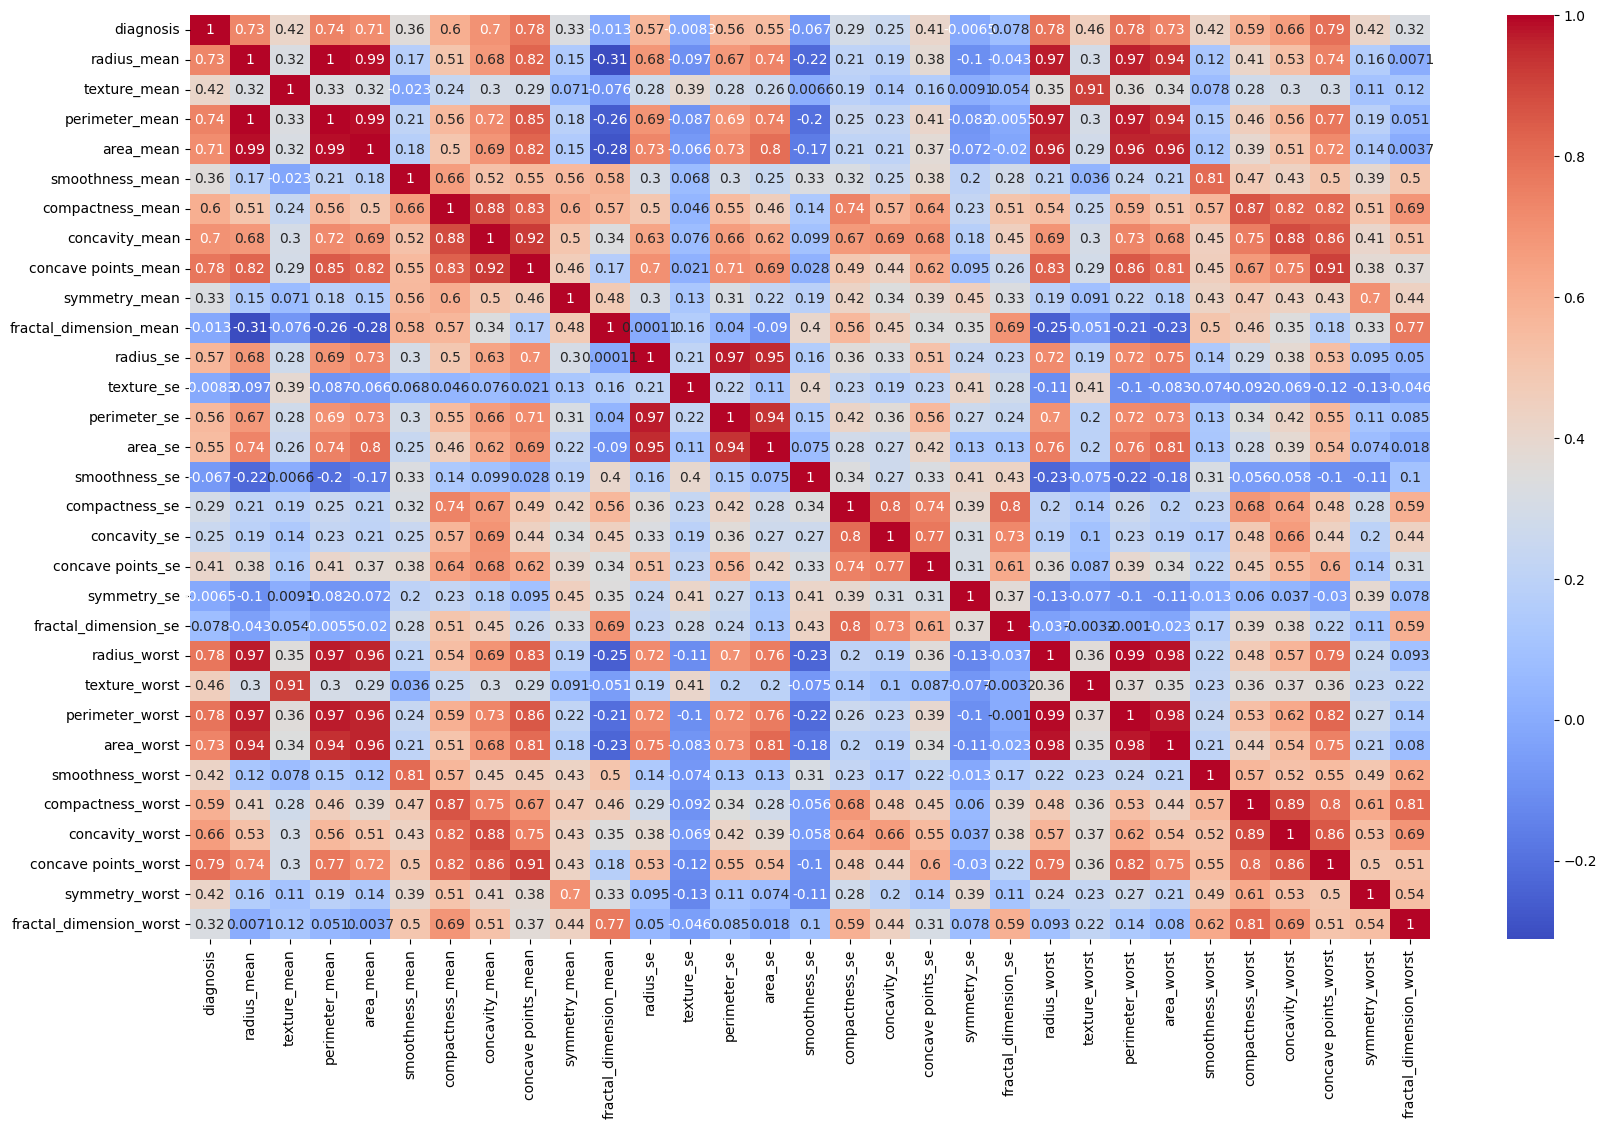

In [537]:
df["diagnosis"] = df["diagnosis"].apply(lambda x: 1 if x == "M" else 0)

plt.figure(figsize=(20, 12))
sns.heatmap(df.drop("id", axis=1).corr(), annot=True, cmap="coolwarm")
plt.show()

# 3. Data preparation
___

### 3.1 Sélection des features

À partir de la heatmap précédente, nous avons décidé dans un premier temps d’isoler les features fortement corrélées entre elles, en particulier celles liées au rayon, au périmètre et à la surface. Dans un second temps, parmi ces features, nous conservons une seule variable par type de mesure (_mean, _se, _worst), en gardant à chaque fois celle qui présente la plus grande corrélation avec la target.

In [538]:
selected_features = [
    "perimeter_mean",
    "texture_worst", 
    "smoothness_worst", 
    "compactness_mean", 
    "concavity_mean", 
    "concave points_worst", 
    "symmetry_worst",
    "fractal_dimension_worst",
    "diagnosis"
]

In [539]:
df = df[selected_features]

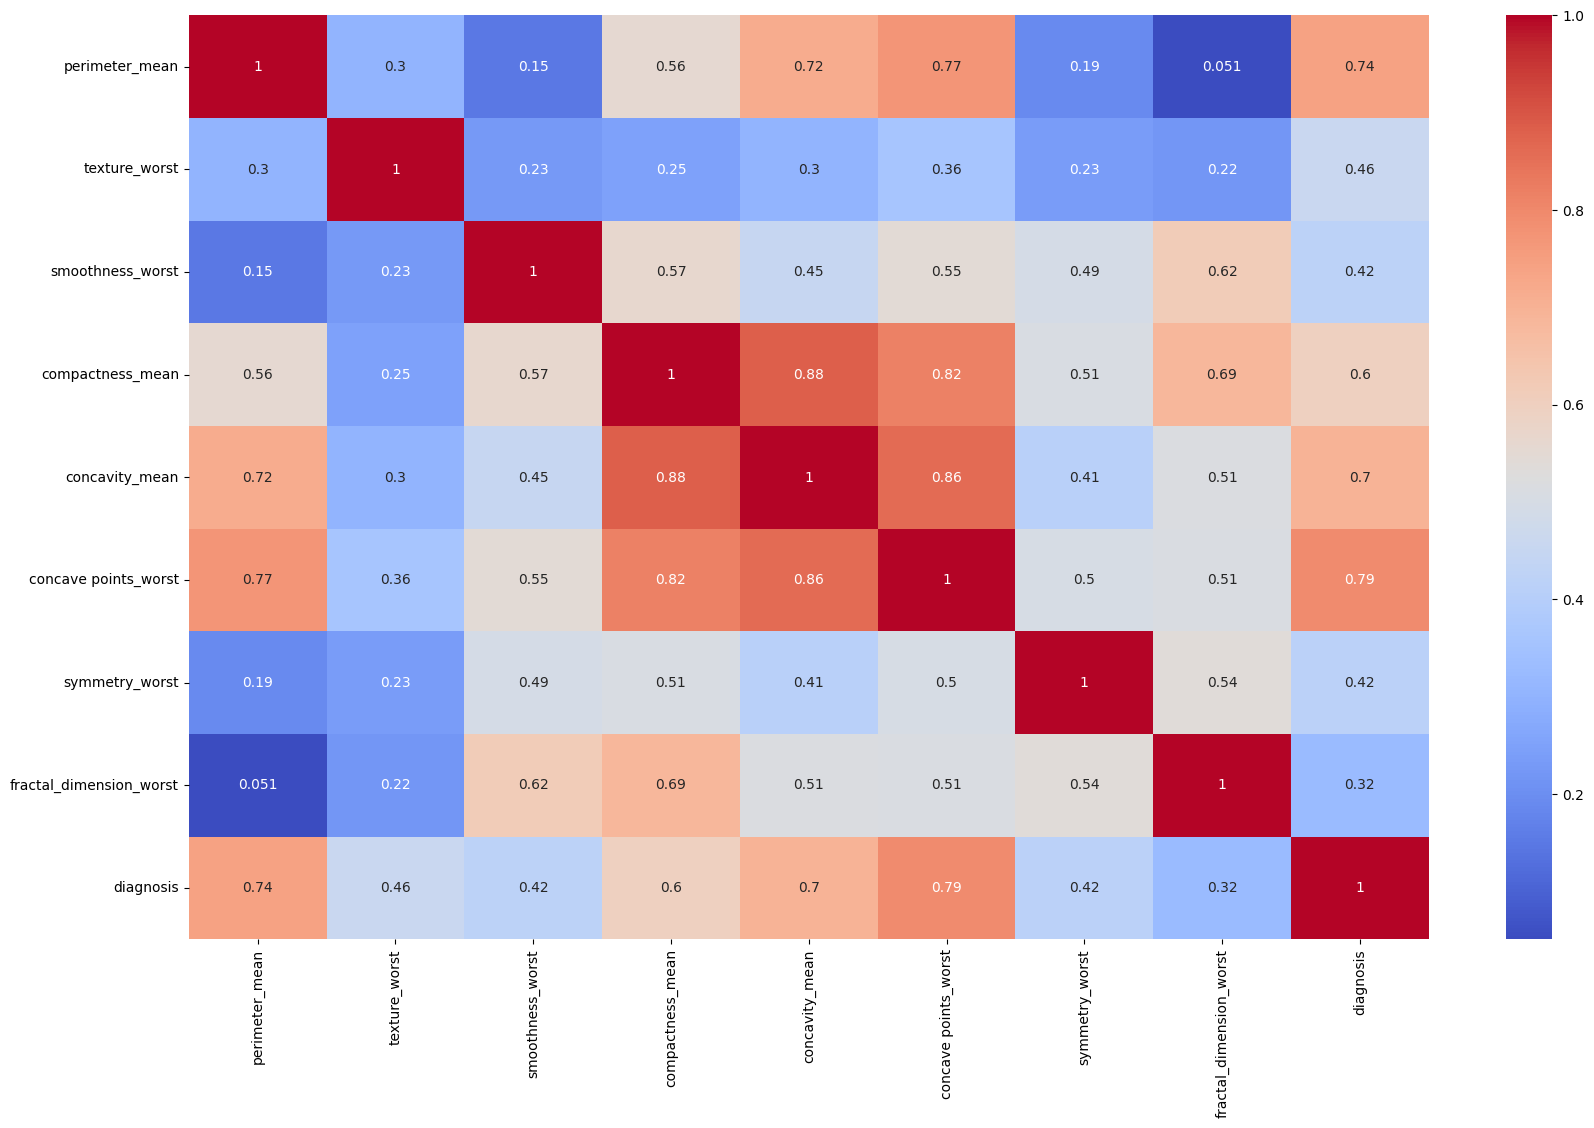

In [540]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

Cependant, d'après la heatmap ci-dessus, parmi ces premières features filtrées, des corrélations persistent. Nous affinons donc la sélection en ne conservant que celles qui présentent la plus forte corrélation avec la variable cible.

In [541]:
selected_features = [
    "texture_worst", 
    "smoothness_worst", 
    "concave points_worst", 
    "symmetry_worst",
    "diagnosis"
]

df = df[selected_features]

### 3.2 Traitement des outliers

D'après les bloxplots étudiés plus haut, les outliers semblent plutôt refléter des cas réels et potentiellement significatifs, notamment dans un contexte médical où certaines mesures peuvent varier fortement d’un individu à l’autre.

Par conséquent, nous faisons le choix de conserver ces outliers dans l’analyse. Ils pourraient en effet :
- représenter des cas cliniques importants
- améliorer la capacité du modèle à détecter des profils atypiques
- contribuer à une meilleure généralisation du modèle

Ce choix sera naturellement réévalué si les performances du modèle ou les diagnostics ultérieurs indiquent une sensibilité excessive à ces valeurs extrêmes.

In [542]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (
        lower_bound, 
        upper_bound, 
        df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        )


display("Outliers texture_worst", detect_outliers(df, "texture_worst")[2])
display("Outliers smoothness_worst", detect_outliers(df, "smoothness_worst")[2])
display("Outliers concave points_worst", detect_outliers(df, "concave points_worst")[2])
display("Outliers symmetry_worst", detect_outliers(df, "symmetry_worst")[2])

'Outliers texture_worst'

,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,diagnosis
219,45.41,0.1408,0.1625,0.2713,1
239,44.87,0.1365,0.2066,0.2853,1
259,49.54,0.1883,0.2014,0.3512,1
265,47.16,0.1401,0.1659,0.2868,1
562,42.79,0.1417,0.2356,0.4089,1


'Outliers smoothness_worst'

,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,diagnosis
3,26.50,0.20980,0.2575,0.6638,1
41,35.34,0.19090,0.1424,0.2964,1
192,20.83,0.07117,0.0000,0.1909,0
203,41.85,0.22260,0.2013,0.4432,1
379,32.82,0.21840,0.2524,0.4154,1
504,16.38,0.19020,0.1025,0.3038,0
505,18.04,0.20060,0.1075,0.2848,0


'Outliers concave points_worst'

,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,diagnosis


'Outliers symmetry_worst'

,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,diagnosis
0,17.33,0.1622,0.26540,0.4601,1
3,26.50,0.2098,0.25750,0.6638,1
8,30.73,0.1703,0.20600,0.4378,1
9,40.68,0.1853,0.22100,0.4366,1
15,37.13,0.1678,0.17120,0.4218,1
22,19.08,0.1390,0.23930,0.4667,1
26,33.21,0.1525,0.27010,0.4264,1
31,28.12,0.1637,0.15460,0.4761,1
34,27.26,0.1446,0.18640,0.4270,1
35,29.02,0.1563,0.18130,0.4863,1


In [543]:
df.head()

,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,diagnosis
0,17.33,0.1622,0.2654,0.4601,1
1,23.41,0.1238,0.1860,0.2750,1
2,25.53,0.1444,0.2430,0.3613,1
3,26.50,0.2098,0.2575,0.6638,1
4,16.67,0.1374,0.1625,0.2364,1


# 4. Train/Test split
___

La séparation se fait selon une proportion de 80/20 (paramètre test_size=0.2), avec une graine aléatoire fixée (random_state=12) afin de garantir la reproductibilité des résultats.

In [544]:
X = df.drop("diagnosis", axis=1).values
y = df["diagnosis"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# 5. Preprocessing
___

Nous procédons à la standardisation des données d'entraînement et de test avec un unique scaler.

Il est inutile de standardiser la variable cible (y) ici car il s’agit d’une classification binaire avec des valeurs 0 et 1.

In [545]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Model training
___

L'entraînement du modèle se fait bien entendu sur les valeurs standardisées.

In [546]:
model = LogisticRegression(solver="liblinear", class_weight="balanced")
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

# 7. Evaluation
___

### 7.1 Matrice de confusion et metrics

Le modèle montre une bonne capacité de classification globale, avec peu d’erreurs. Les faux négatifs sont légèrement plus nombreux que les faux positifs, ce qui pourrait être un point de vigilance selon le contexte (ex : un faux négatif en dépistage médical peut être plus critique qu’un faux positif).

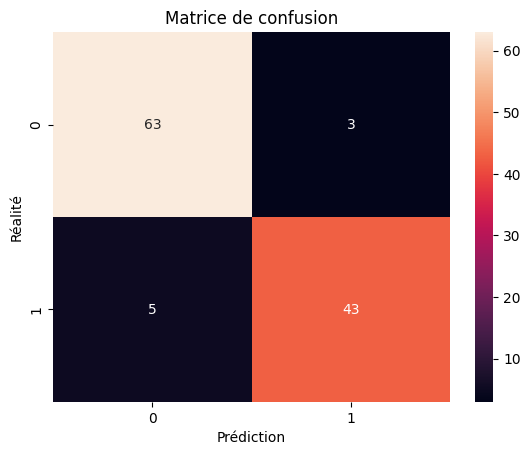

In [547]:
y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True)
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()

In [548]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Recall :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))

Accuracy : 0.9298245614035088
Precision : 0.9347826086956522
Recall : 0.8958333333333334
F1-score : 0.9148936170212766


### 7.2 Courbe ROC-AUC

Le modèle a un comportement quasi-idéal, capable de bien séparer les classes, même quand on fait varier le seuil de décision.
Cela renforce les très bons résultats observés avec la matrice de confusion et les métriques classiques (accuracy, précision, rappel, F1).

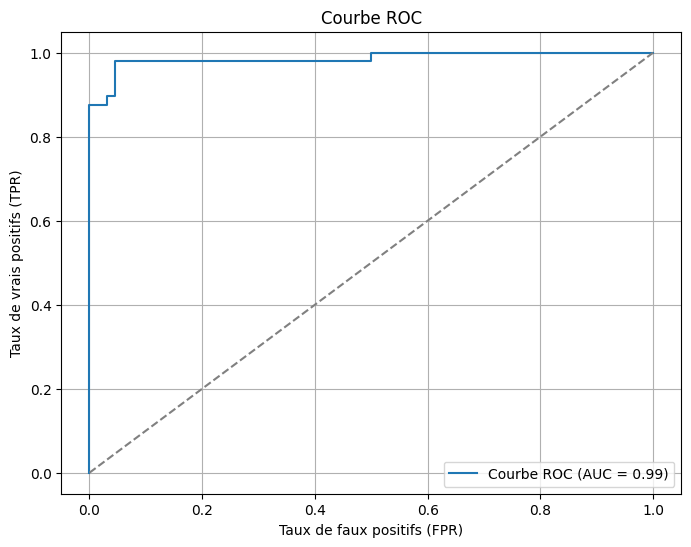

Thresholds :  [           inf 9.99940803e-01 6.18213170e-01 5.23200149e-01
 5.12842019e-01 5.00305006e-01 3.55129671e-01 2.61953757e-02
 2.60586915e-02 2.59548577e-04]


In [549]:
# Prédictions sous forme de probabilités
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Calcul des courbes ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Affichage
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.grid()
plt.show()

# Affichage des seuils de décisions testés automatiquement par roc_curve
print("Thresholds : ", thresholds)

# 8. Sauvegarde du modèle et du scaler
___

In [550]:
joblib.dump(model, "models/model_logistic_regression.pkl")
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']

# 9. Utilisation du modèle
___

In [551]:
%run app.py

Bienvenue dans l'outil de prédiction du diagnostic cellulaire.


KeyboardInterrupt: Interrupted by user